In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

import plotly.express as px
import joblib


import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv(r"E:\GL\USL Case study\Country-data.csv")

In [4]:
data.head(2)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
data.shape

(167, 10)

In [7]:
data.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


## **we will perform EDA**

<Axes: >

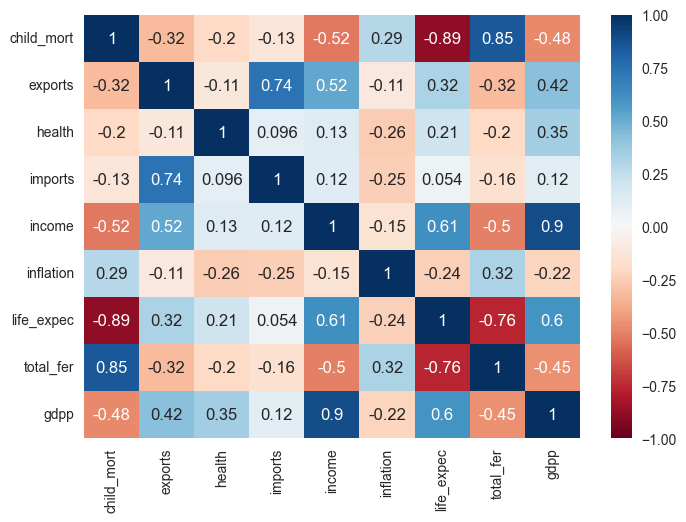

In [9]:
# Correlation Heatmap
sns.heatmap(data.corr(numeric_only=True),annot=True,vmin=-1,cmap='RdBu')

In [10]:
# before we begin visualizing let's convert country to index
data.set_index('country',inplace=True)
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


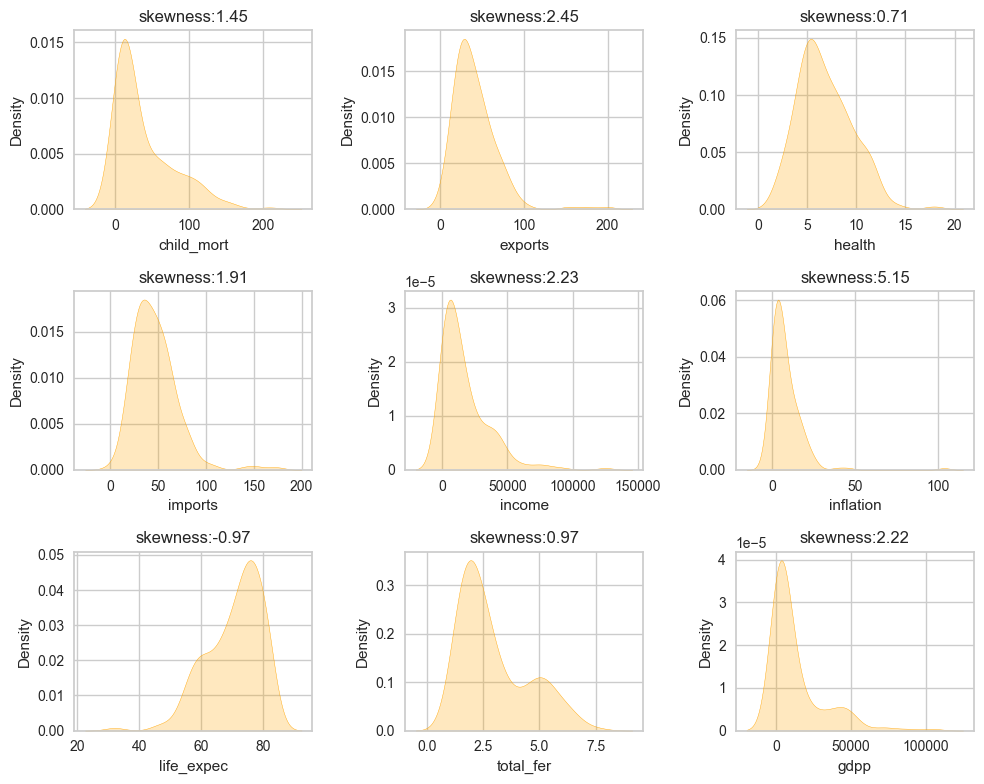

In [11]:
# Univariate analysis
t=1
plt.figure(figsize=(10,8))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.kdeplot(data=data,x=i,fill=True,color='orange')
    plt.title(f'skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

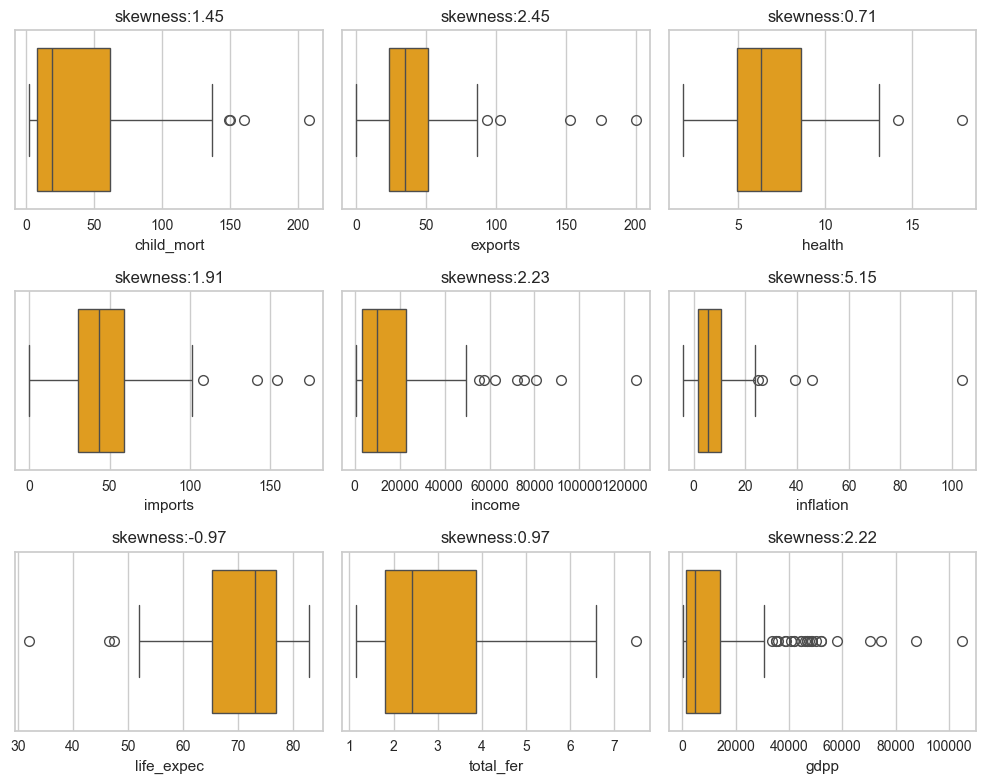

In [12]:
# Univariate analysis
t=1
plt.figure(figsize=(10,8))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,color='orange')
    plt.title(f'skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

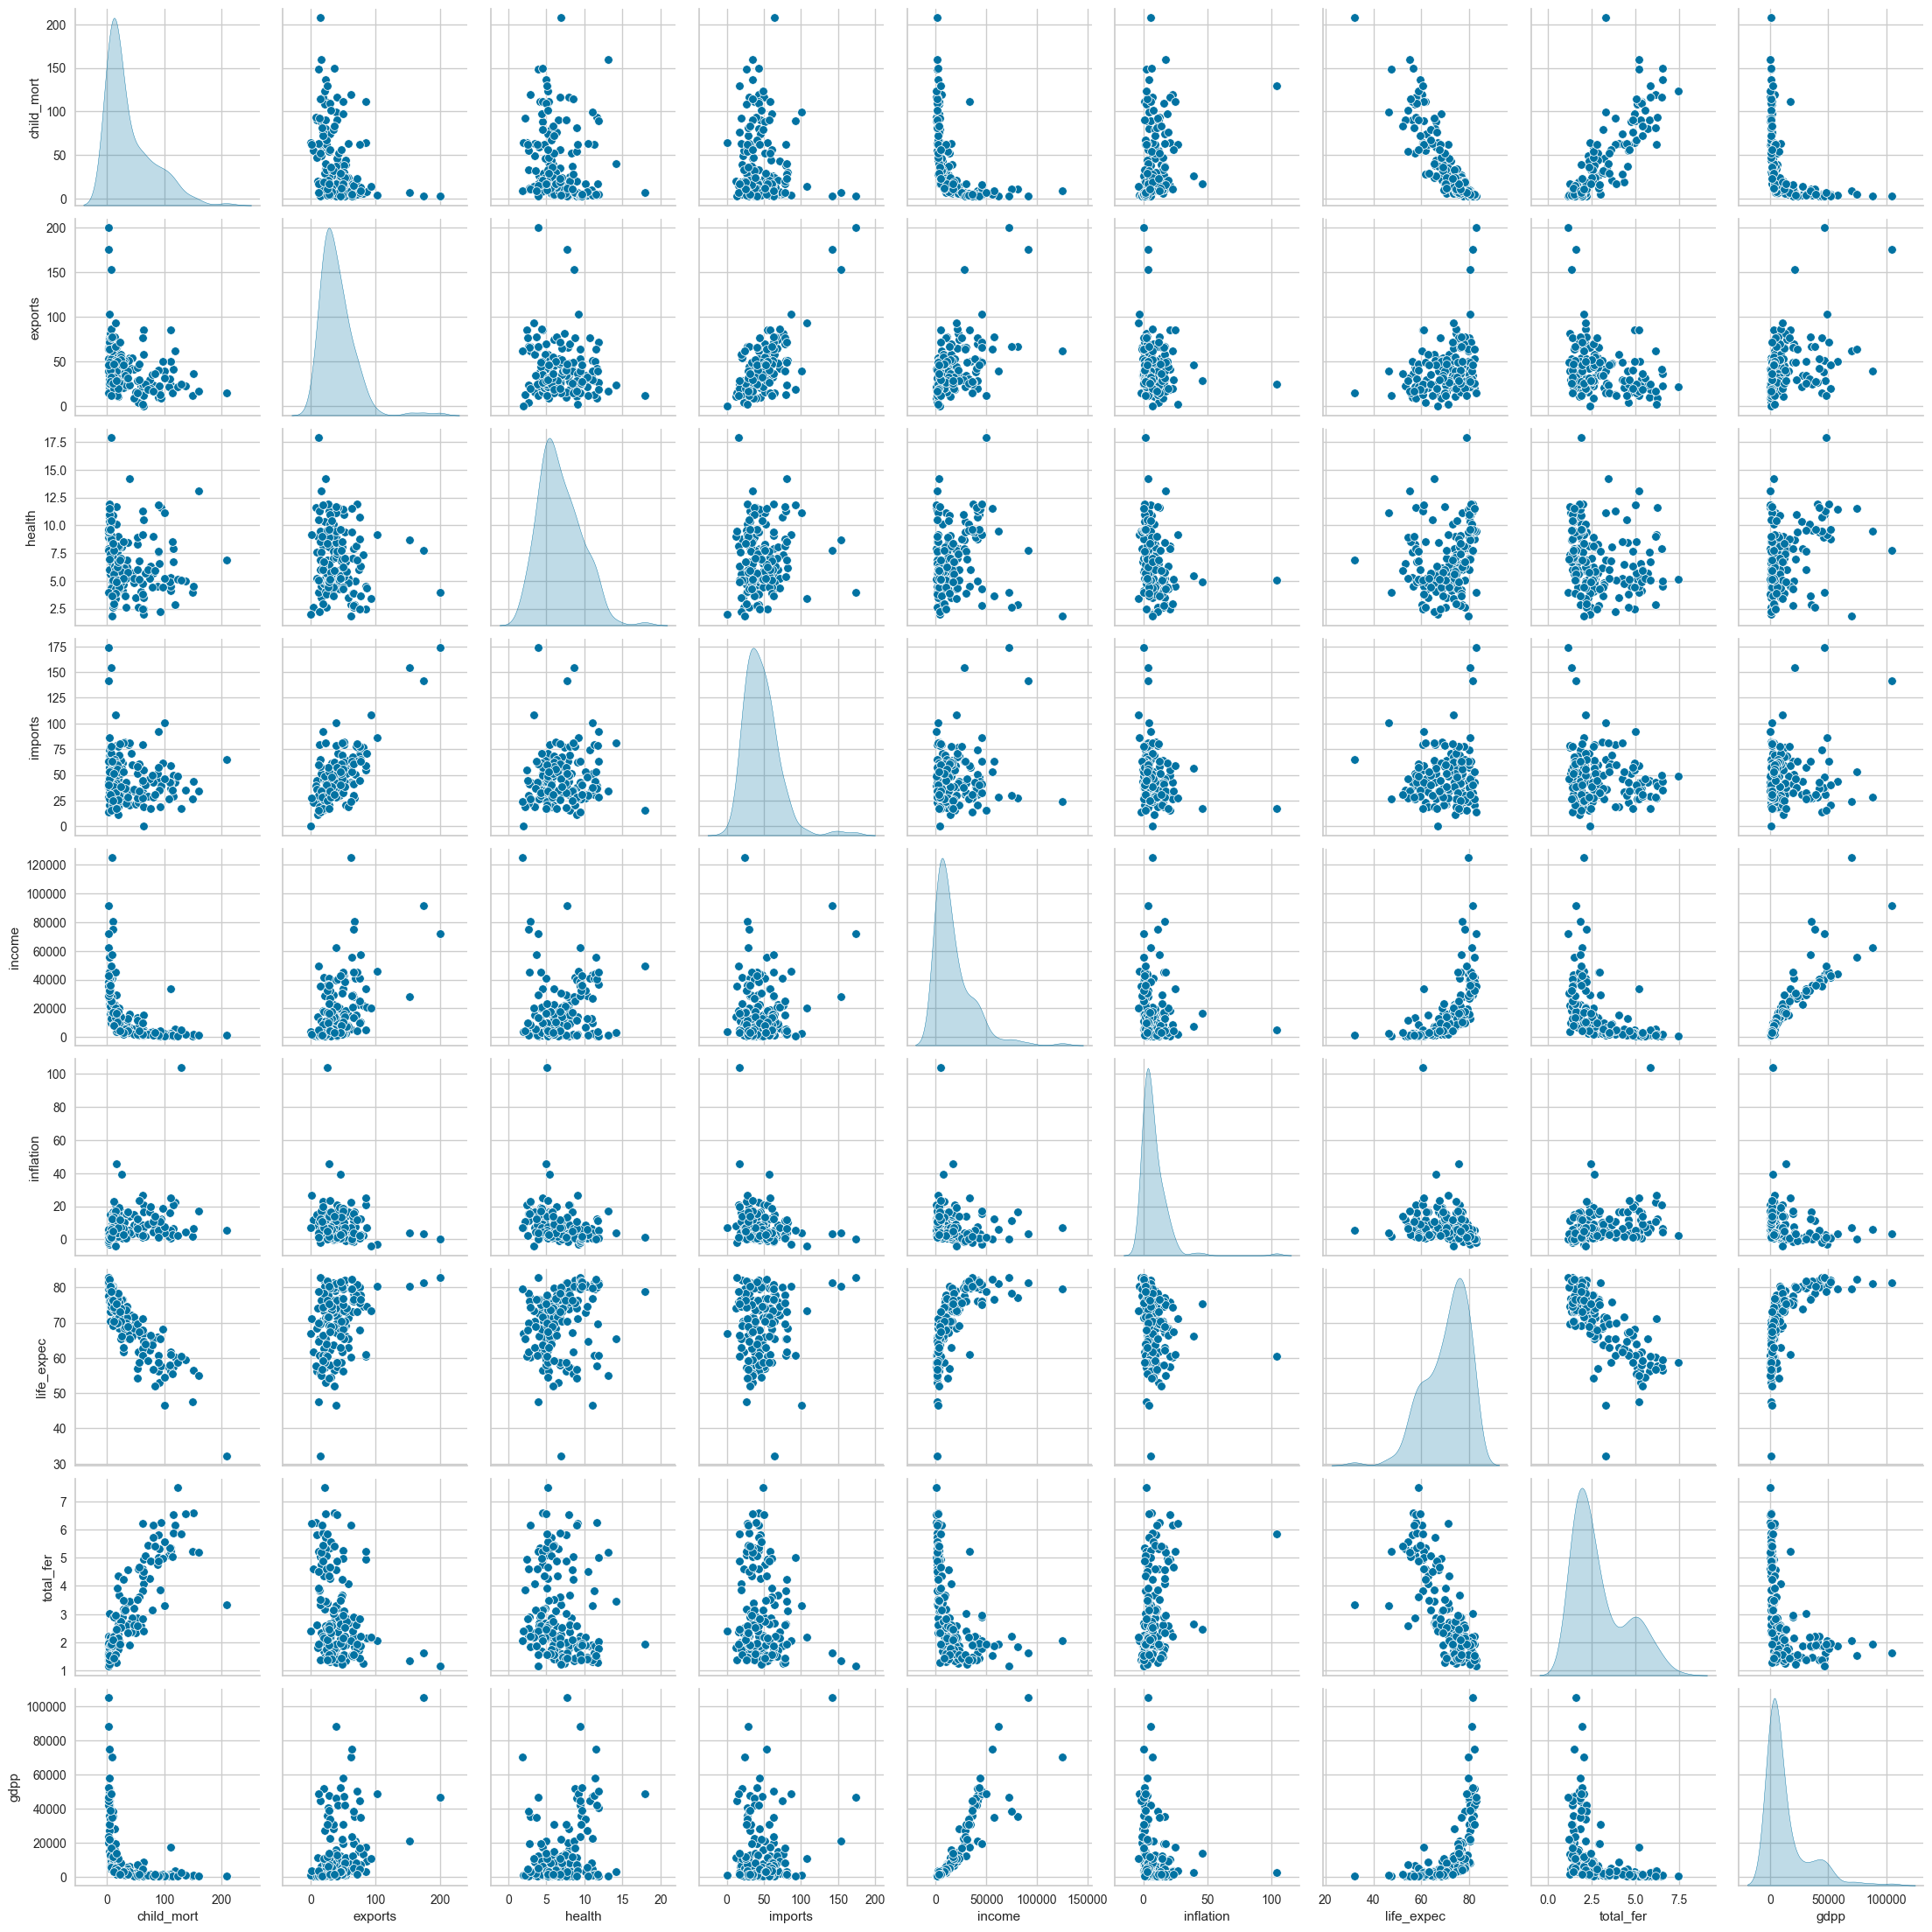

In [13]:
# Bivariate analysis
sns.pairplot(data,diag_kind='kde')
plt.show()

## **Preprocessing**

In [14]:
# check for missing values

data.isnull().sum().sum()

np.int64(0)

# inference: 
* there is no missing value in the data

In [15]:
#we will treat the outliers
# we will use capping using IQR method
# in order to cap only the extreme ones let's leep whisker length to 2.5
for i in data.columns:
    q1,q3=np.quantile(data[i],[0.25,0.75])
    iqr=q3-q1
    ul,ll=q3+2.5*iqr,q1-2.5*iqr
    data[i]=data[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

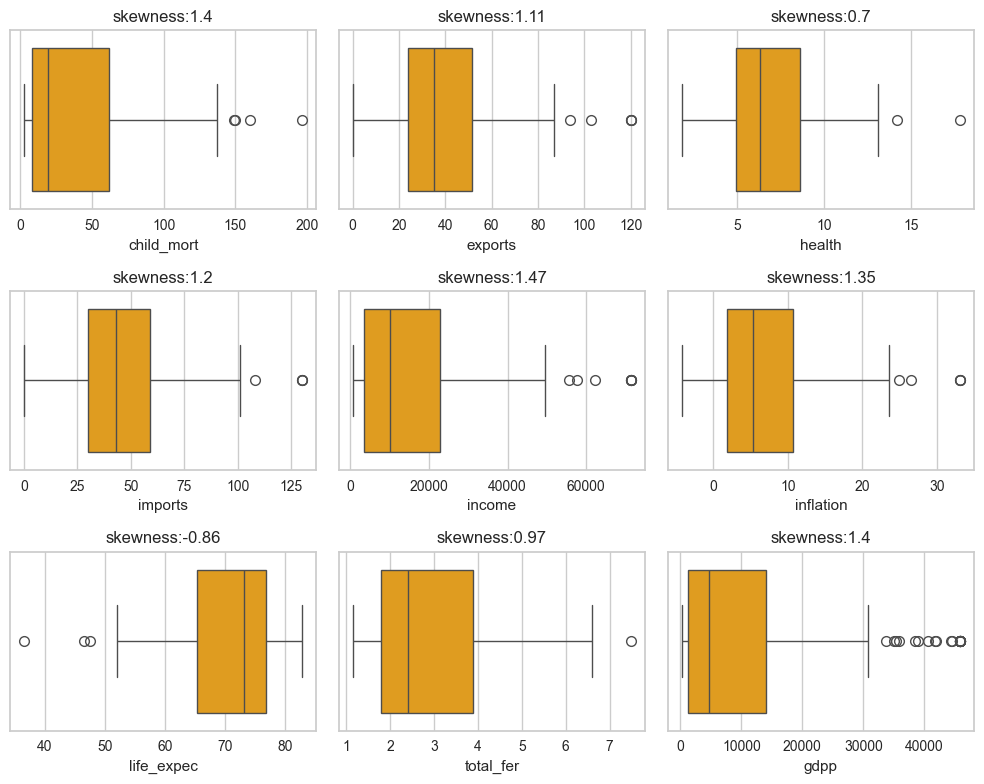

In [16]:
# Univariate analysis
t=1
plt.figure(figsize=(10,8))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,color='orange')
    plt.title(f'skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [17]:
# Let's apply pca on the dasta before we proceed with clustering. Just have better visualization and better clustering
# In pca we need to pass standardize data. So let's import the functions from libraries

# Let's create and instance of scalling
scaler= StandardScaler()

# Let's also create an instance for PCA
pca=PCA(n_components=5,random_state=2)

# Let's create pipeline for the above cases
pipeline=Pipeline([('scale',scaler),('PCA',pca)])

In [18]:
pipeline.fit(data)

,steps,"[('scale', ...), ('PCA', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,5
,copy,True
,whiten,False
,svd_solver,'auto'


In [19]:
pca.explained_variance_ratio_

array([0.4758564 , 0.16714568, 0.1354519 , 0.10172608, 0.06629691])

In [20]:
pca.explained_variance_ratio_.cumsum()


# At n_components =5 we are able to explain ~ 95% of variance, which is good enough 
# so 9-D data can be reduced to 5-D data

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697])

In [21]:
final_data=pipeline.transform(data)

In [22]:
# transform return the array. Lets convert it into dataset
final_data=pd.DataFrame(final_data,columns=['PC1','PC2','PC3','PC4','PC5'],index=data.index)

In [23]:
final_data.head(2)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623


In [24]:
# K-Means clustering
kelbow=KElbowVisualizer(estimator=KMeans(random_state=2),k=10)

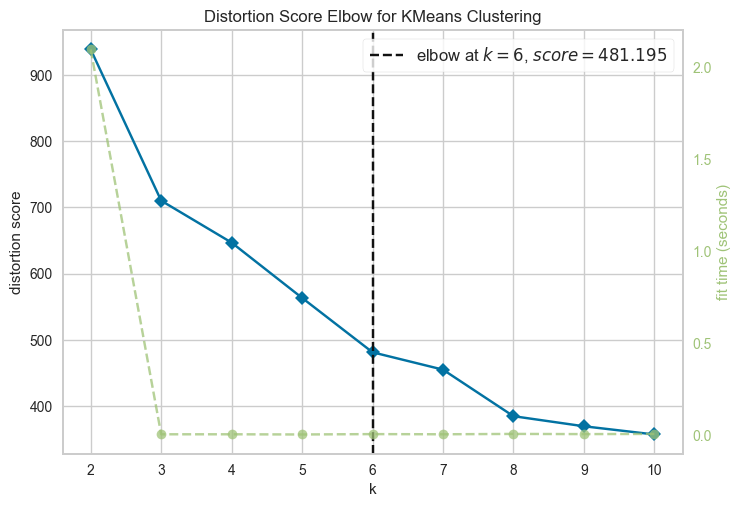

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
kelbow.fit(final_data)
kelbow.show()

Although the above plot mark the elbow at k=6 but we can see the significant drop in distortion score from k=2 to k=3. As we increase the number of cluster it might  become over fitted. lets explore sillhouette visualizer to identify as the correct visualizer

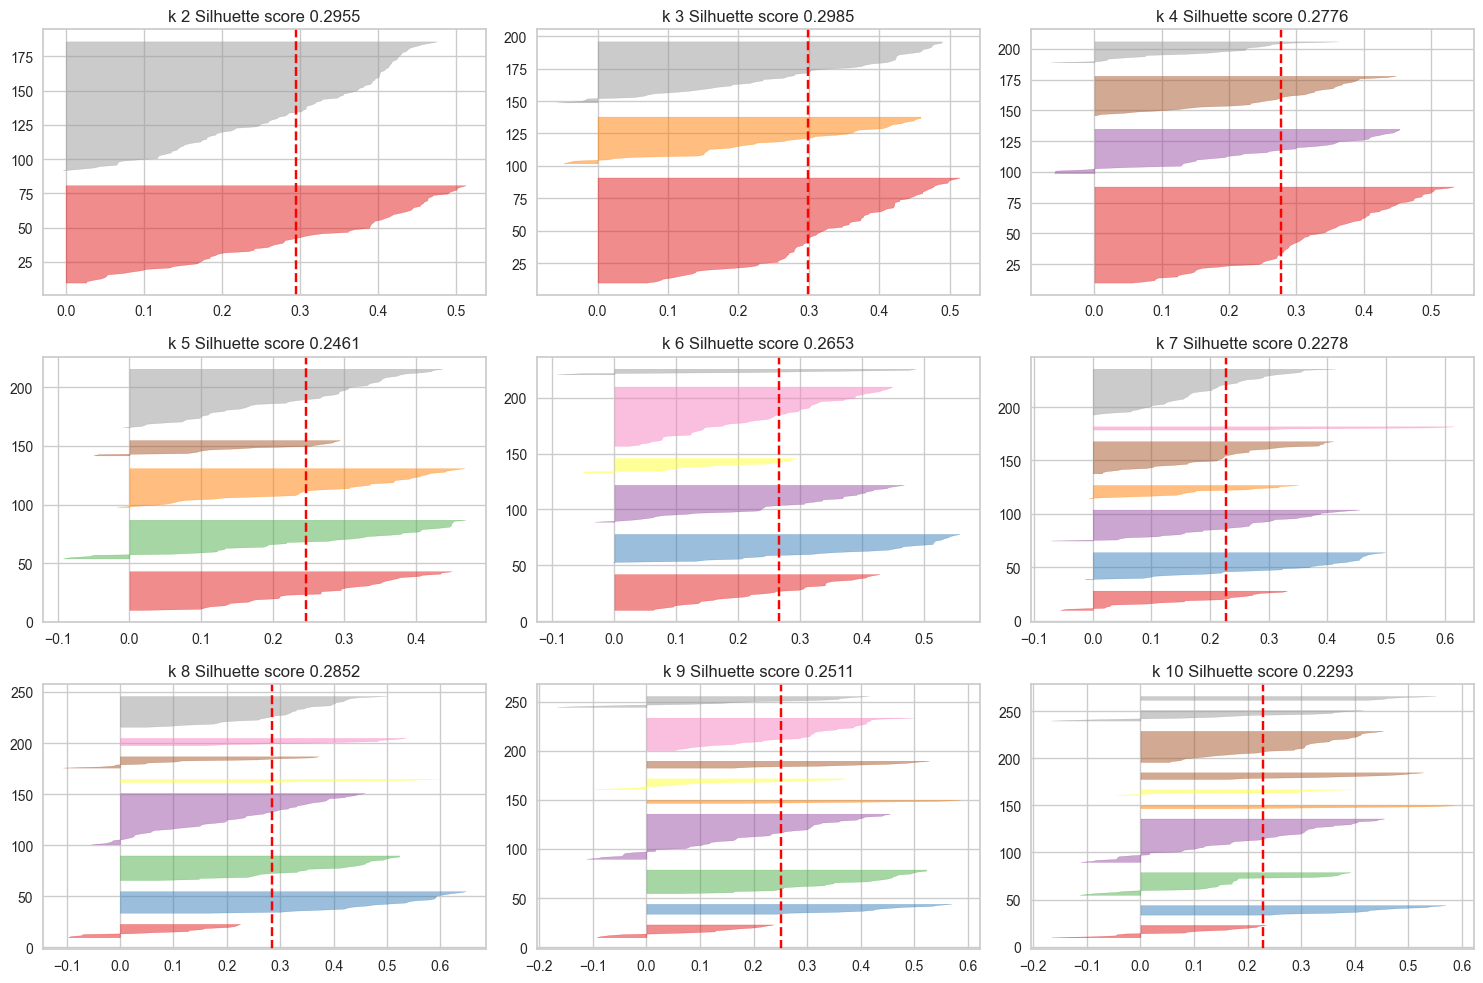

In [26]:
t =1
plt.figure(figsize=(15,10))
for i in range(2,11):
    plt.subplot(3,3,t)
    model = KMeans(n_clusters=i,random_state=2)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(final_data)
    plt.title(f'k {i} Silhuette score {round(sil_viz.silhouette_score_,4)}')
    t+=1
plt.tight_layout()
plt.show()

After analyzing Elbow plot and sillhouettw visualizer let's go with k=3, although there are few datapoints that have been missclassified, but we see no drop in sillhouette score and there is good enoug hdata in every cluster als from k-elbow plot significant drop in WCSS was observed from k=2 to k=3

In [27]:
final_kmeans= KMeans(n_clusters=3,random_state=2)

In [28]:
labels=final_kmeans.fit_predict(final_data)

In [29]:
print('Silhouette Score: ',silhouette_score(final_data,labels))

Silhouette Score:  0.2984578234829662


In [30]:
final_data['labels']=labels
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5,labels
country,,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800,2
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623,0
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119,0


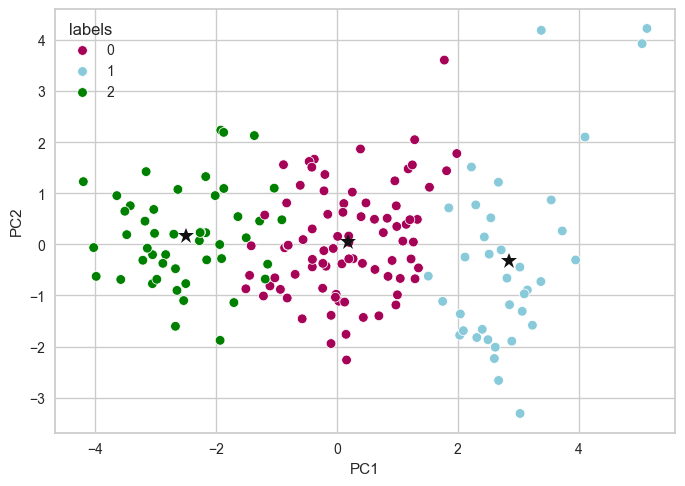

In [31]:
# let's visualize the clusters 
# in order to get the best visualizer lets choose pc1,pc2, as they have maximum variance 
centroids=final_kmeans.cluster_centers_
centroids

sns.scatterplot(data=final_data,x='PC1',y='PC2',palette=['m','c','green'],hue='labels')
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms=12,color='k')
plt.show()

In [32]:
# to 
data['Labels']=labels
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,2
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0


In [33]:
data.groupby(by='Labels').mean(
    
)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Labels,,,,,,,,,
0,21.508537,40.797317,6.231951,48.097561,12281.097561,7.474744,72.875610,2.311707,6291.146341
1,5.237838,53.575000,8.780270,49.129054,42690.878378,2.588432,79.956757,1.755676,36905.405405
2,92.131771,28.546229,6.296458,41.443040,3937.770833,10.438854,59.438542,4.953958,1902.916667


After studying the above data we can conclude that countries that have been assigned to clister 2 can be called under developed, while cluster 1 are countries belonging to cluster 0 are doing average in most of the factors but struggling in some economic factors linke GDPA/income and expenditure on health

In [34]:
data['Labels']=data['Labels'].map({0:"Developing",1:"Developed",2:"Underdeveloped"})

In [35]:
data[data['Labels']=="Underdeveloped"].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
       'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype='object', name='country')

TypeError: could not convert string to float: 'Underdeveloped'

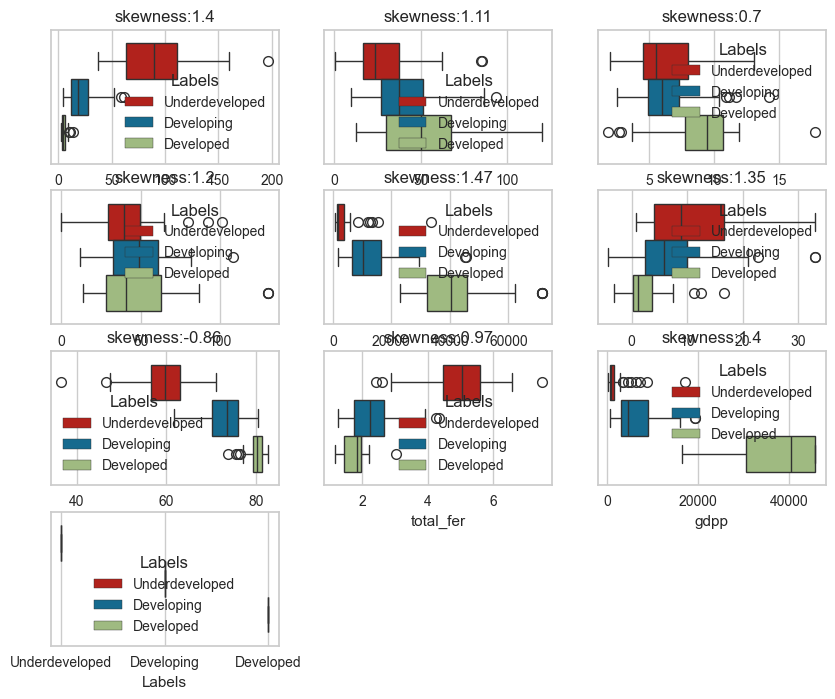

In [37]:
# Univariate analysis
t=1
plt.figure(figsize=(10,8))
for i in data.columns:
    plt.subplot(4,3,t)
    sns.boxplot(data=data,x=i,hue='Labels',palette=['r','b','g'])
    plt.title(f'skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [ ]:
# World Map

px.choropleth(data_frame=data,locationmode='country names',locations=data.index,color='Labels',color_discrete_map={'Underdeveloped':'red','Developing':'blue','Developed':'green'})

C:\Users\keshav\AppData\Local\Temp\ipykernel_19732\1941504658.py:3: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'colorscale': [[0.0, 'red'], [1.0, 'red']],
              'geo': 'geo',
              'hovertemplate': 'Labels=Underdeveloped<br>country=%{location}<extra></extra>',
              'locationmode': 'country names',
              'locations': array(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
                                  'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
                                  'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea',
                                  'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
                                  'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
                                  'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
                                  'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
                                  'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste',
                                  'Togo', 'Uganda', 'Yemen', 'Zambia'], dtype=object),
              'name': 'Underdeveloped',
              'showlegend': True,
              'showscale': False,
              'type': 'choropleth',
              'z': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1]},
             {'colorscale': [[0.0, 'blue'], [1.0, 'blue']],
              'geo': 'geo',
              'hovertemplate': 'Labels=Developing<br>country=%{location}<extra></extra>',
              'locationmode': 'country names',
              'locations': array(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
                                  'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
                                  'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
                                  'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
                                  'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
                                  'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India',
                                  'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
                                  'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
                                  'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
                                  'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
                                  'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
                                  'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles',
                                  'Solomon Islands', 'Sri Lanka', 'St. Vincent and the Grenadines',
                                  'Suriname', 'Tajikistan', 'Thailand', 'Tonga', 'Tunisia', 'Turkey',
                                  'Turkmenistan', 'Ukraine', 'Uruguay', 'Uzbekistan', 'Vanuatu',
                                  'Venezuela', 'Vietnam'], dtype=object),
              'name': 'Developing',
              'showlegend': True,
              'showscale': False,
              'type': 'choropleth',
              'z': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
             {'colorscale': [[0.0, 'green'], [1.0, 'green']],
              'geo': 'geo',
              'hovertemplate': 'Labels=Developed<br>country=%{location}<extra></extra>',
              'locationmode': 'country names',
     

## **Deployment**

In [38]:
input_data=data.iloc[0,:-1].values
input_data

array([np.float64(90.2), np.float64(10.0), np.float64(7.58),
       np.float64(44.9), np.float64(1610.0), np.float64(9.44),
       np.float64(56.2), np.float64(5.82), np.float64(553.0)],
      dtype=object)

In [39]:
final_input_data=pipeline.transform([input_data])

In [40]:
final_kmeans.predict(final_input_data)[0]

np.int32(2)

In [41]:
with open('pipeline.joblib','wb')as file:
    joblib.dump(pipeline,file)

In [42]:
with open('model.joblib','wb')as file:
    joblib.dump(final_kmeans,file)